In [81]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from colorama import Fore, Style
from scipy.optimize import fsolve, curve_fit
import yfinance as yf
import akshare as ak
import sys
sys.path.append('../src') 
from utils import plot_candlestick

In [82]:
def get_optimum_clusters(
    df: pd.DataFrame,
    saturation_point):
    '''
    param df: dataframe
    param saturation_point: The amount of difference we are willing to detect
    return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''
    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]
    return optimum_clusters

def support_and_resistance(df, saturation_point: float=0.05):
    '''
    Calculate support and resistance using KMean
    '''
    df_plot = df
    # low_clusters = get_optimum_clusters(df_plot[(df_plot['low']!=df_plot['open'])&(df_plot['low']!=df_plot['close'])][['date',"low"]].set_index('date'), saturation_point)
    low_clusters = get_optimum_clusters(df_plot[['date',"low"]].set_index('date'), saturation_point)
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    # high_clusters = get_optimum_clusters(df_plot[(df_plot['high']!=df_plot['open'])&(df_plot['high']!=df_plot['close'])][['date',"high"]].set_index('date'), saturation_point)
    high_clusters = get_optimum_clusters(df_plot[['date',"high"]].set_index('date'), saturation_point)
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    return low_centers, high_centers

In [47]:
# Tongxin ETF
etf_code = "sh515880"  # ETF代码
start_date = "20220101"  # 开始日期
end_date = "20250508"  # 结束日期

# 调用 AKShare 的 fund_etf_hist_sina 接口获取数据
etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)

etf_hist.tail()

,date,open,high,low,close,volume
1364,2025-04-28,1.168,1.173,1.155,1.159,117767300
1365,2025-04-29,1.151,1.162,1.142,1.155,73247400
1366,2025-04-30,1.153,1.166,1.149,1.161,99198700
1367,2025-05-06,1.173,1.205,1.173,1.204,210604100
1368,2025-05-07,1.218,1.228,1.193,1.206,143159000


[[0.89904762]
 [0.99012903]
 [1.03922857]
 [1.10403125]
 [1.16412048]
 [1.25188889]
 [1.33046429]
 [1.39683333]] [[0.93728571]
 [1.0165082 ]
 [1.06808955]
 [1.13606667]
 [1.19993506]
 [1.29153846]
 [1.3672963 ]
 [1.44074468]]


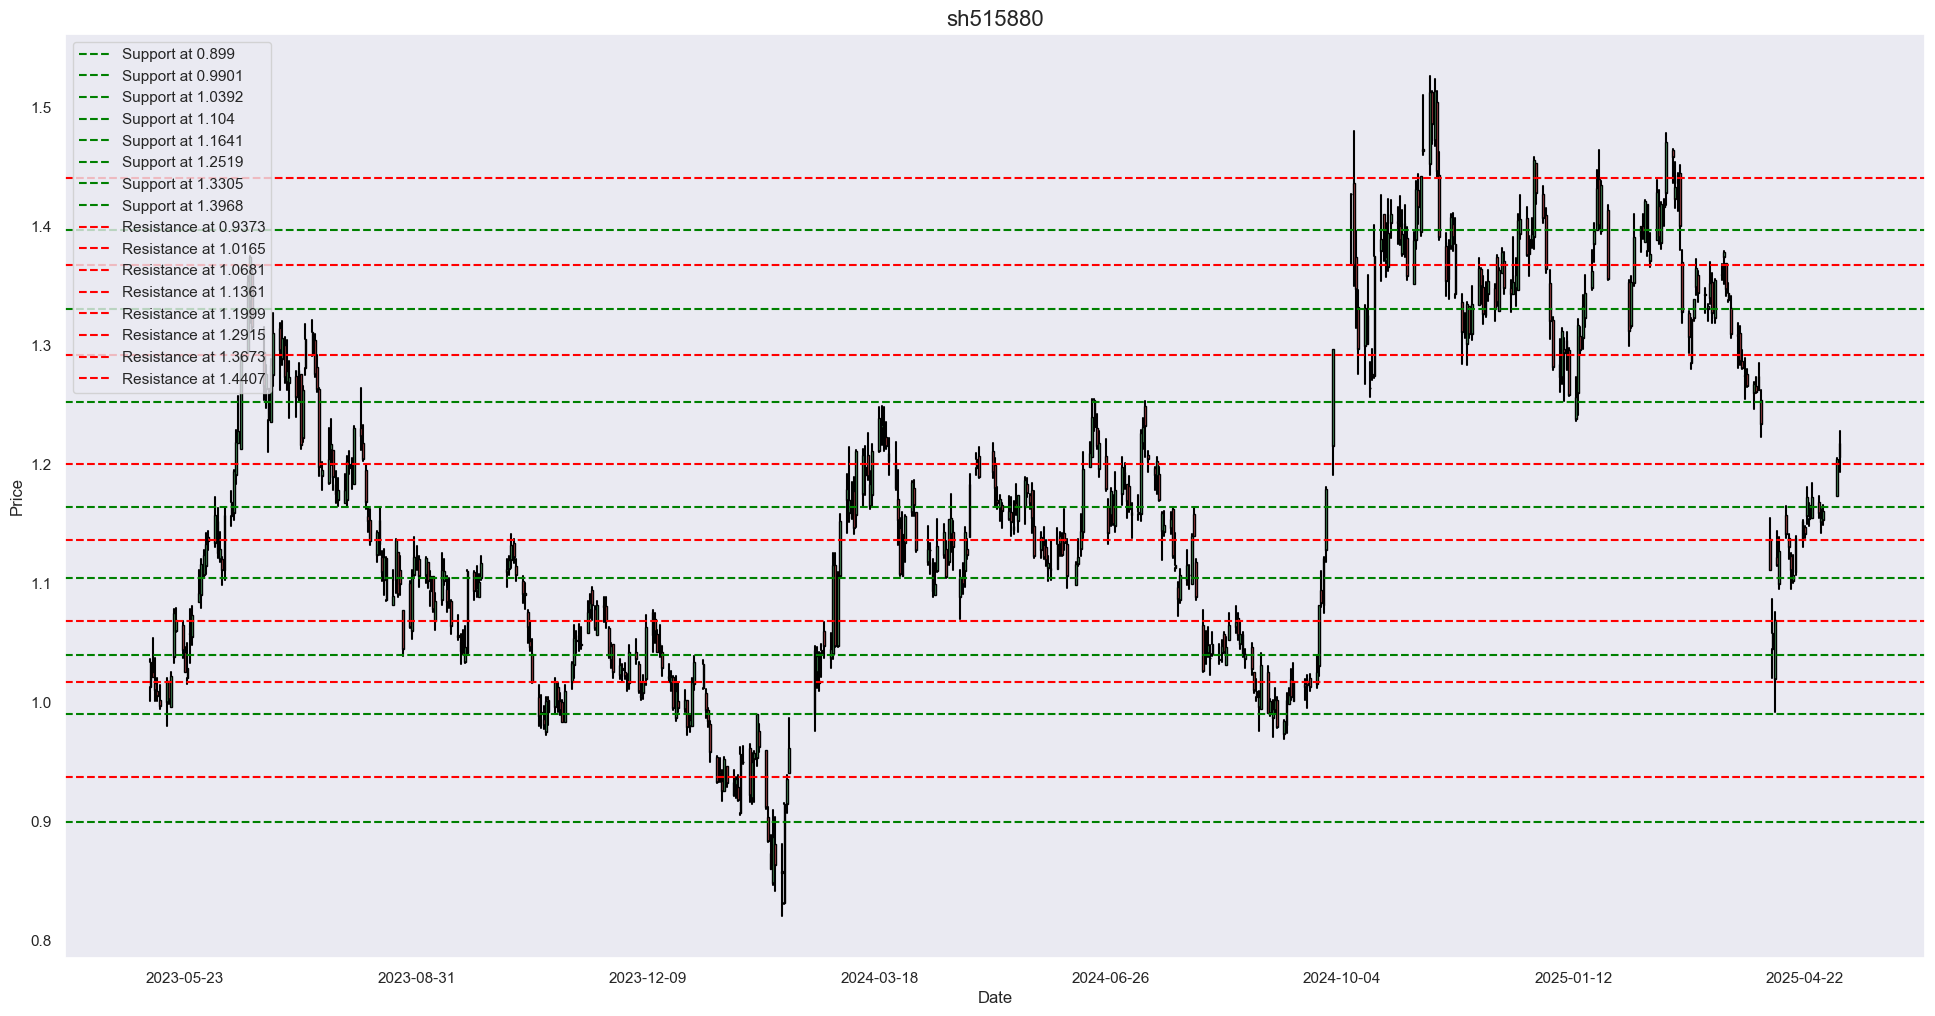

In [49]:
start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d')
etf_hist['date'] = pd.to_datetime(etf_hist['date'])
df_plot = etf_hist[etf_hist['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
ax = plot_candlestick(df_plot, figsize=(24,12))
low_centers, high_centers = support_and_resistance(df_plot)
print(low_centers, high_centers)
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--', label=f'Support at {round(low[0],4)}')
for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--', label=f'Resistance at {round(high[0],4)}')
ax.set_title("sh515880", fontsize=16)
ax.legend(loc='upper left')

In [53]:
etf_code = "sh513180"  # ETF代码
start_date = "20220101"  # 开始日期
end_date = "20221231"  # 结束日期

etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)
etf_hist.tail()

,date,open,high,low,close,volume
933,2025-03-31,0.750,0.752,0.734,0.741,7351263171
934,2025-04-01,0.748,0.758,0.744,0.749,8068711000
935,2025-04-02,0.744,0.758,0.739,0.748,7144843500
936,2025-04-03,0.733,0.744,0.727,0.733,8748133300
937,2025-04-07,0.675,0.680,0.660,0.660,7324210938


In [71]:
etf_spot = ak.fund_etf_spot_em()
# 筛选出通信ETF（sh515880）的数据
etf_data = etf_spot[etf_spot["代码"] == "515880"]
etf_data

,代码,名称,最新价,IOPV实时估值,基金折价率,涨跌额,涨跌幅,成交量,成交额,开盘价,...,小单净流入-净额,小单净流入-净占比,现手,买一,卖一,最新份额,流通市值,总市值,数据日期,更新时间
1,515880,通信ETF,1.238,1.2396,0.13,0.032,2.65,1710937,210552441.0,1.204,...,-10115521.0,-4.8,-545,1.238,1.239,2.545462e+09,3151282332,3151282332,2025-05-08,2025-05-08 12:09:19+08:00


In [75]:
fund_etf_category_sina_df = ak.fund_etf_category_sina()
fund_etf_category_sina_df.head()

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量,成交额
0,sz169201,浙商鼎盈LOF,1.467,0.011,0.755,1.461,1.479,1.456,1.458,1.467,1.458,6307,9244
1,sz169106,东方红创优定开,1.064,0.000,0.000,1.057,1.064,1.064,1.057,1.064,1.057,6500,6873
2,sz169105,东方红睿华LOF,1.285,0.000,0.000,1.287,1.295,1.285,1.285,1.285,1.285,300,386
3,sz169104,东方红睿满LOF,1.497,0.007,0.470,1.484,1.497,1.490,1.465,1.498,1.465,31200,46334
4,sz169103,东方红睿轩定开,1.790,0.015,0.845,1.780,1.801,1.775,1.780,1.790,1.778,9000,16044


In [77]:
fund_etf_category_sina_df[fund_etf_category_sina_df["代码"] == "sh513180"]

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量,成交额


In [81]:
fund_etf_category_sina_df[fund_etf_category_sina_df["代码"].str[0:2] == "sh"]

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量,成交额
271,sh506008,科创板长城,0.759,-0.001,-0.132,0.758,0.759,0.760,0.759,0.760,0.759,35800,27173
272,sh506006,汇添富科创板,0.812,0.003,0.371,0.809,0.812,0.809,0.805,0.812,0.805,52278,42264
273,sh506005,科创板博时,0.831,0.002,0.241,0.830,0.831,0.829,0.830,0.831,0.825,1267900,1050043
274,sh506003,富国科创板,0.705,-0.002,-0.283,0.704,0.705,0.707,0.706,0.707,0.703,822439,579491
275,sh506002,易方达科创板,0.924,-0.003,-0.324,0.923,0.926,0.927,0.922,0.930,0.917,421091,388813
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,sh501009,生物科技LOF,1.133,0.002,0.177,1.133,1.134,1.131,1.126,1.135,1.126,63500,71885
380,sh501008,互联网医疗LOFC,0.926,0.009,0.981,0.922,0.928,0.917,0.917,0.929,0.917,65400,60504
381,sh501007,互联网医疗LOF,0.954,0.014,1.489,0.950,0.954,0.940,0.947,0.954,0.947,41100,39103
382,sh501005,精准医疗LOF,0.839,-0.001,-0.119,0.839,0.844,0.840,0.838,0.840,0.834,96700,80984


In [79]:
spot_hist_sge_df = ak.spot_hist_sge(symbol='Au99.99')
spot_hist_sge_df['date']= pd.to_datetime(spot_hist_sge_df['date'])
spot_hist_sge_df.head()

,date,open,close,low,high
0,2016-12-19,262.45,262.76,262.02,263.50
1,2016-12-20,262.88,262.06,261.42,263.70
2,2016-12-21,262.40,260.97,258.60,262.65
3,2016-12-22,261.18,260.00,259.05,261.18
4,2016-12-23,258.95,260.07,258.70,260.37


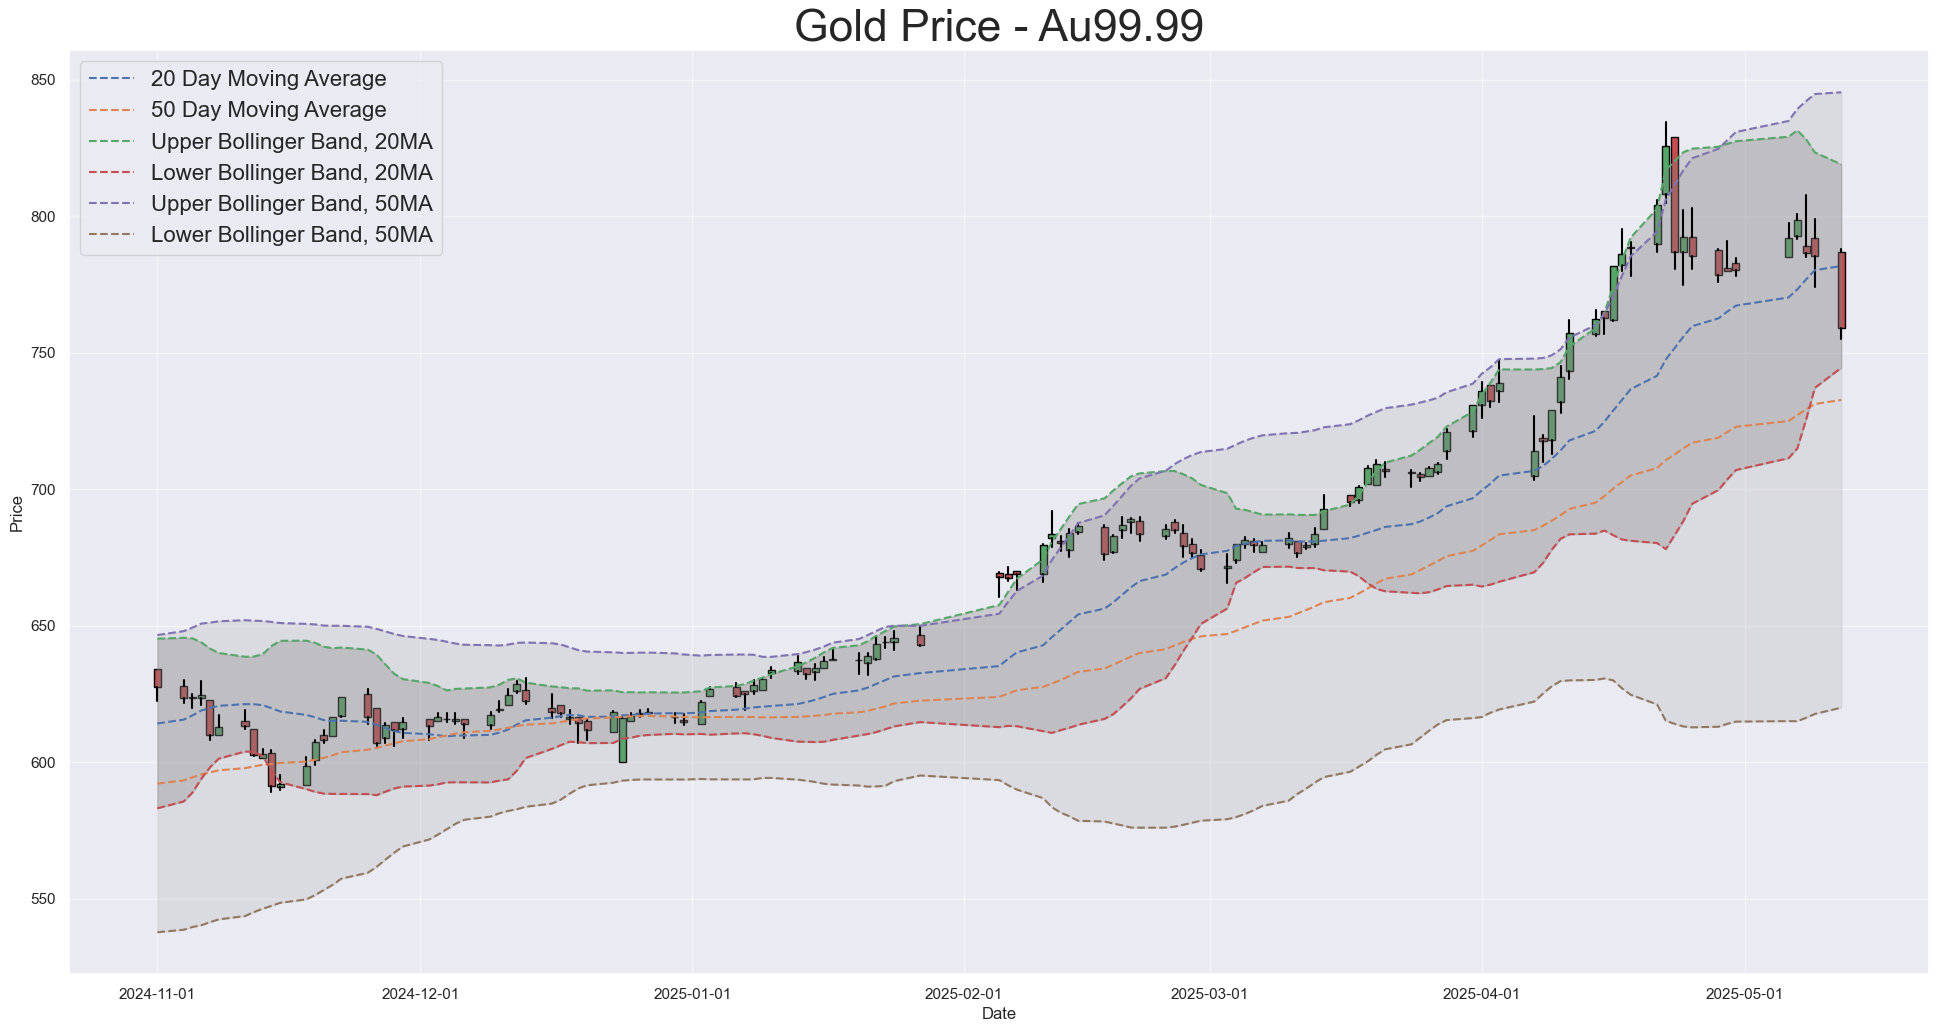

In [83]:
spot_hist_sge_df['20 Day MA'] = spot_hist_sge_df['close'].rolling(window=20).mean()
spot_hist_sge_df['20 Day STD'] = spot_hist_sge_df['close'].rolling(window=20).std()
spot_hist_sge_df['50 Day MA'] = spot_hist_sge_df['close'].rolling(window=50).mean()
spot_hist_sge_df['50 Day STD'] = spot_hist_sge_df['close'].rolling(window=50).std()        
# Calculate upper and lower bands
spot_hist_sge_df['Upper Band - 20MA'] = spot_hist_sge_df['20 Day MA'] + (spot_hist_sge_df['20 Day STD'] * 2)
spot_hist_sge_df['Lower Band - 20MA'] = spot_hist_sge_df['20 Day MA'] - (spot_hist_sge_df['20 Day STD'] * 2)
spot_hist_sge_df['Upper Band - 50MA'] = spot_hist_sge_df['50 Day MA'] + (spot_hist_sge_df['50 Day STD'] * 2.5)
spot_hist_sge_df['Lower Band - 50MA'] = spot_hist_sge_df['50 Day MA'] - (spot_hist_sge_df['50 Day STD'] * 2.5)
spot_hist_sge_df['120 Day MA'] = spot_hist_sge_df['close'].rolling(window=120).mean()
spot_hist_sge_df['200 Day MA'] = spot_hist_sge_df['close'].rolling(window=200).mean()

df = spot_hist_sge_df[spot_hist_sge_df['date']>='2024-11-01']

ax = plot_candlestick(df, figsize=(24,12))
ax.grid(True, alpha=0.5)
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')

ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

ax.set_title('Gold Price - Au99.99', fontsize=32)
ax.legend(fontsize=16)

[[478.71780488]
 [508.5265    ]
 [549.12043478]
 [566.51772727]
 [592.75954545]
 [614.02477273]
 [631.41809524]
 [677.027     ]
 [713.84117647]
 [776.985     ]] [[482.11525   ]
 [509.145     ]
 [553.58435484]
 [572.37214286]
 [611.18958333]
 [633.13486486]
 [683.77172414]
 [714.61846154]
 [751.82714286]
 [799.988125  ]]


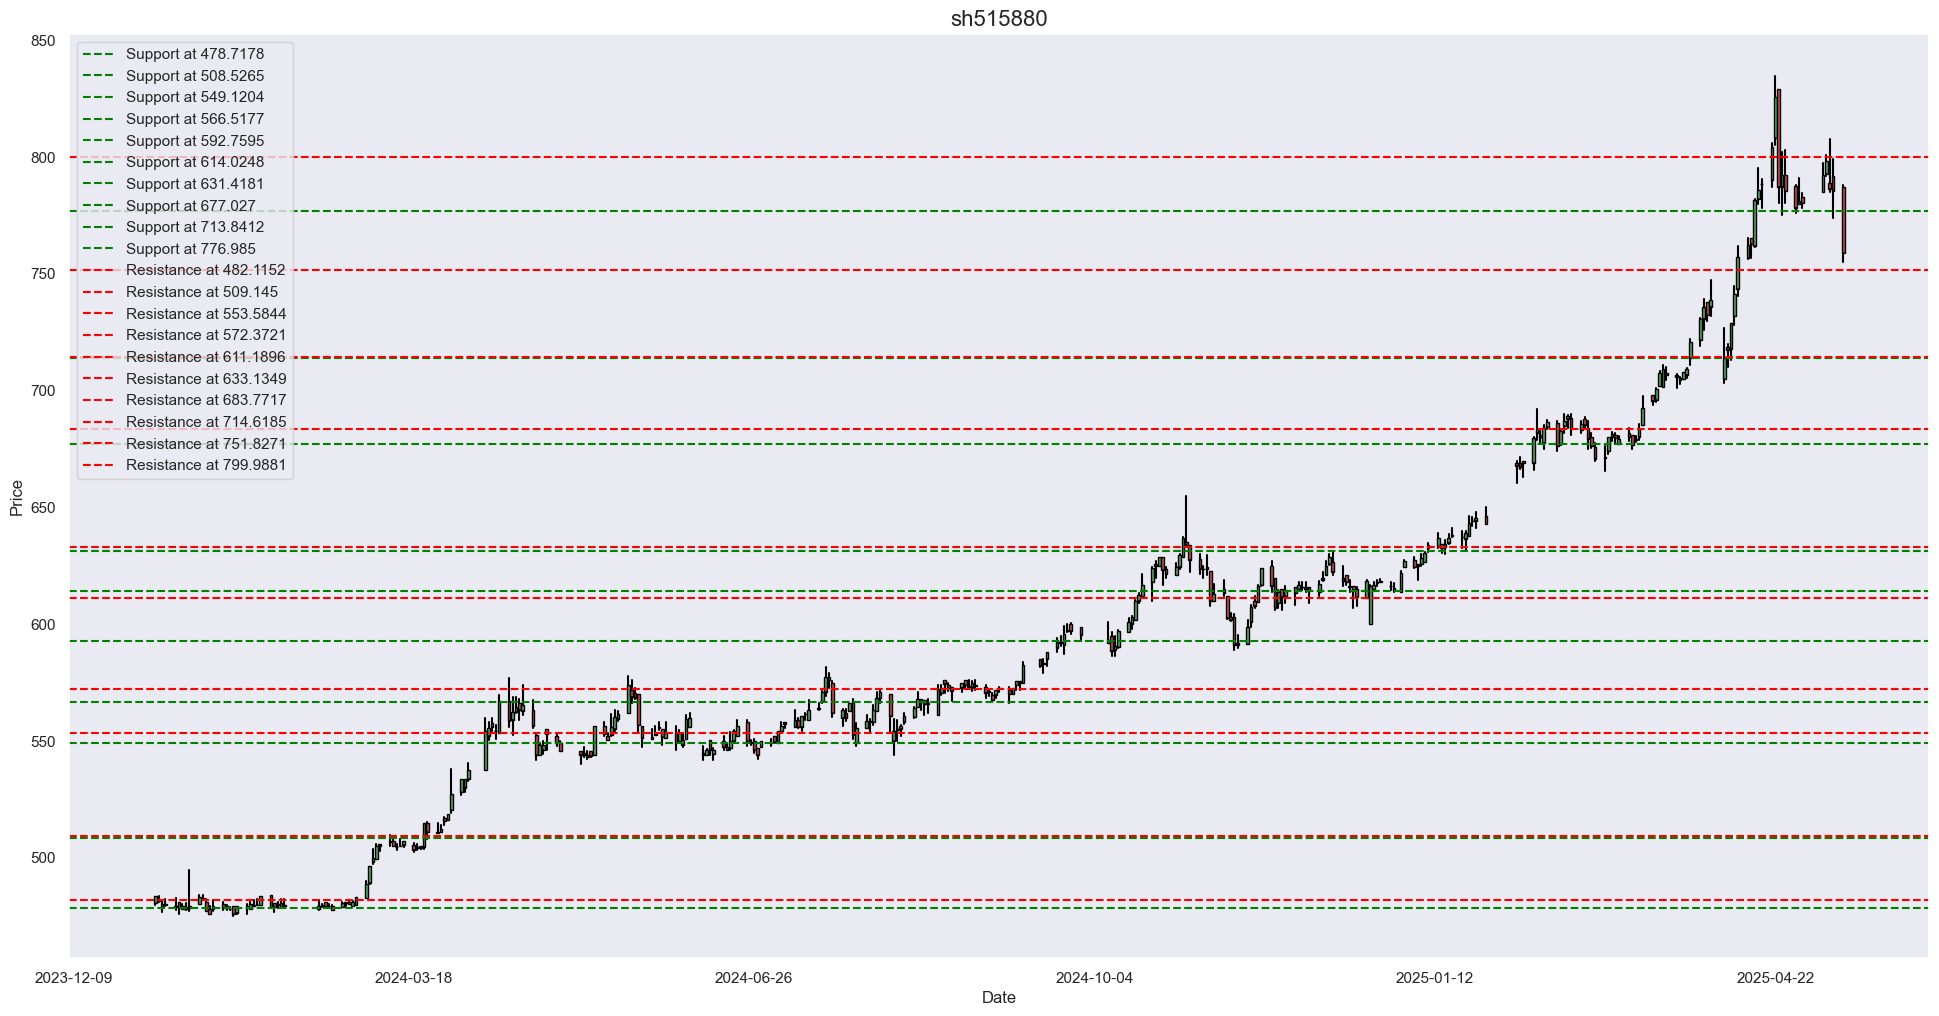

In [85]:
df_plot = spot_hist_sge_df[spot_hist_sge_df['date'].between('2024-01-01',datetime.today().strftime('%Y-%m-%d'))]
ax = plot_candlestick(df_plot, figsize=(24,12))
low_centers, high_centers = support_and_resistance(df_plot)
print(low_centers, high_centers)
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--', label=f'Support at {round(low[0],4)}')
for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--', label=f'Resistance at {round(high[0],4)}')
ax.set_title("sh515880", fontsize=16)
ax.legend(loc='upper left')

In [86]:
spot_hist_sge_df.tail()

,date,open,close,low,high,20 Day MA,20 Day STD,50 Day MA,50 Day STD,Upper Band - 20MA,Lower Band - 20MA,Upper Band - 50MA,Lower Band - 50MA,120 Day MA,200 Day MA
2029,2025-05-06,785.0,792.20,785.00,797.5,770.2540,29.440669,724.9884,43.968943,829.135338,711.372662,834.910757,615.066043,669.291583,634.29750
2030,2025-05-07,792.9,798.51,791.80,801.0,773.2325,29.117469,727.1750,44.861295,831.467438,714.997562,839.328237,615.021763,670.747667,635.50025
2031,2025-05-08,789.0,786.50,785.00,807.9,776.8585,25.660663,729.2356,45.177942,828.179826,725.537174,842.180456,616.290744,672.096083,636.63665
2032,2025-05-09,792.0,785.50,774.05,799.0,780.2585,21.558936,731.2340,45.416770,823.376373,737.140627,844.775926,617.692074,673.558500,637.78465
2033,2025-05-12,787.0,759.00,755.00,788.0,781.7645,18.634687,732.7106,45.087559,819.033875,744.495125,845.429497,619.991703,674.776417,638.77540
